<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLatFIAN2020/blob/master/seminar02/MLatFIAN2020_seminar02_LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## y = kx + b

Let's start with a toy 1D problem, where the true dependence is
$$y=k\cdot x+b+\text{noise}$$

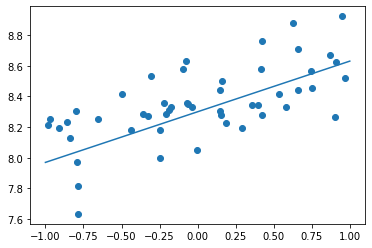

In [ ]:
def linear_function(x):
  return 0.33 * x + 8.3

def gen_dataset(N, func, lims=(-1., 1.), noise_lvl=0.2):
  x = np.random.uniform(*lims, size=N)
  y = func(x) + noise_lvl * np.random.normal(size=x.shape)
  return x[:,None], y

X, y = gen_dataset(50, linear_function)
x = np.linspace(-1, 1, 101)
plt.plot(x, linear_function(x))
plt.scatter(X, y);

### `LinearRegression` from `sklearn`

[0.26871663] 8.348591963825735


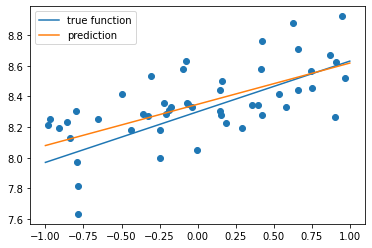

In [ ]:
# The following class implements the analytical solution for
# linear regression with the MSE loss
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X, y)

x = np.linspace(-1, 1, 101)
plt.plot(x, linear_function(x), label='true function')
plt.scatter(X, y);
plt.plot(x, model.predict(x[:,None]), label='prediction')
plt.legend()

print(model.coef_, model.intercept_)

### Sidenote: making contour plots

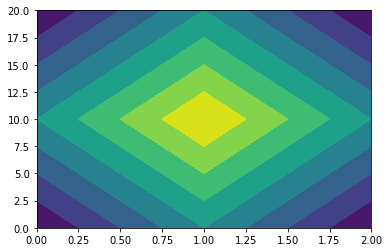

In [ ]:
### Sidenote: making contour plots (level maps)

plt.contourf(
    [[0., 1., 2.], # matrix of X
     [0., 1., 2.],
     [0., 1., 2.]],
    [[ 0.,  0.,  0.], # matrix of Y
     [10., 10., 10.],
     [20., 20., 20.]],
    [[-1., 0., -1.], # matrix of Z
     [ 0., 1.,  0.],
     [-1., 0., -1.]]
);

In [ ]:
### 2D matrices of X and Y (as above) can be
### created from 1D vectors using np.meshgrid:

for i in np.meshgrid([0., 1., 2], [0., 10., 20.]):
  print(i)

[[0. 1. 2.]
 [0. 1. 2.]
 [0. 1. 2.]]
[[ 0.  0.  0.]
 [10. 10. 10.]
 [20. 20. 20.]]


### MSE as a function of model parameters

Let's see what MSE looks like as a function of model parameters:

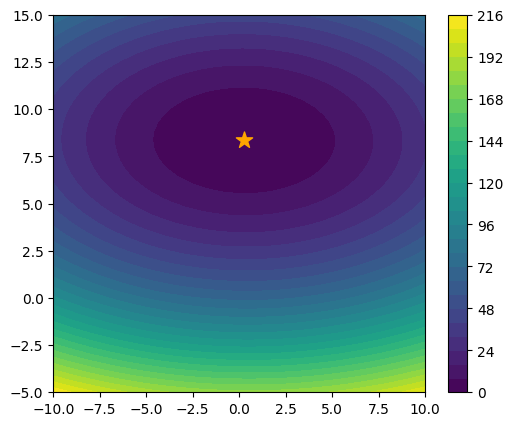

In [ ]:
# Creating a grid of model parameter values:
ww, bb = np.meshgrid(
    np.linspace(-10., 10., 50),
    np.linspace(-5., 15., 50)
)

# Your turn: calculate the map of MSE values on the grid defined above, i.e.
# for each (w, b) in (ww, bb) calculate MSE for the model y = w * x + b.
# Avoid using loops.
MSE_map = <YOUR CODE>

# Automatic checks
assert MSE_map.shape == ww.shape
for i in [0, -1]:
  for j in [0, -1]:
    assert np.isclose(
        MSE_map[i, j],
        ((ww[i, j] * X.ravel() + bb[i, j] - y)**2).mean()
    ), f'assert failed for point {i, j}'

# Plotting:
plt.figure(figsize=(6, 5), dpi=100)
plt.colorbar(plt.contourf(ww, bb, MSE_map, levels=30))
plt.scatter(model.coef_, model.intercept_, marker='*', s=150, c='orange');

## Polynomial fit

Now let's take some arbitrary function:

In [ ]:
def true_function(x):
  return np.sin(3 * x + 0.8) + np.sin(1. / (x + 1.23))

Obviously, we won't get a good fit with an ordinary linear regression:

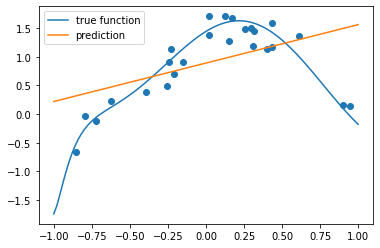

In [ ]:
model = LinearRegression()
X, y = gen_dataset(25, true_function)

model.fit(X, y)

x = np.linspace(-1, 1, 101)
plt.plot(x, true_function(x), label='true function')
plt.scatter(X, y);
plt.plot(x, model.predict(x[:,None]), label='prediction')
plt.legend();

### `PolynomialFeatures` and pipelines

Even though our design matrix has only one column:
$$X=
\begin{pmatrix}
x_1 \\
x_2 \\
\vdots \\
x_N
\end{pmatrix},
$$
we can expand it with powers of $x$ to fit a polynomial:
$$X'=
\begin{pmatrix}
x_1 & (x_1)^2 & \ldots & (x_1)^k \\
x_2 & (x_2)^2 & \ldots & (x_2)^k \\
\vdots & \vdots & \ddots & \vdots \\
x_N & (x_N)^2 & \ldots & (x_N)^k
\end{pmatrix},
$$

such that:

$$\frac{1}{N}\left\Vert X'\cdot w - y\right\Vert^2\to \underset{w}{\text{min}}$$

This functionality is implemented in `sklearn.preprocessing.PolynomialFeatures`:

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly_expand = PolynomialFeatures(3)
poly_expand.fit_transform(np.arange(5)[:,None])

array([[ 1.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.],
       [ 1.,  2.,  4.,  8.],
       [ 1.,  3.,  9., 27.],
       [ 1.,  4., 16., 64.]])

One can combine `PolynomialFeatures` (and any other transformers) along with the model into a single pipeline:

In [ ]:
from sklearn.pipeline import make_pipeline

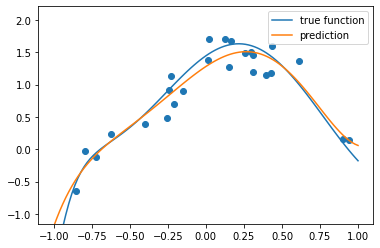

In [ ]:
# The first parameter is the power of expansion. Try playing around with it.
poly_expand = PolynomialFeatures(5, include_bias=False)
linear_model = LinearRegression()
model = make_pipeline(
    poly_expand, linear_model
)

model.fit(X, y)

x = np.linspace(-1, 1, 101)
plt.plot(x, true_function(x), label='true function')
plt.scatter(X, y);
plt.plot(x, model.predict(x[:,None]), label='prediction')
plt.ylim(y.min() - 0.5, y.max() + 0.5)
plt.legend();

Now we want to plot 2D projections of MSE as a function of model parameters.

In [ ]:
from tqdm import trange, tqdm

100%|██████████| 6/6 [00:00<00:00,  8.02it/s]


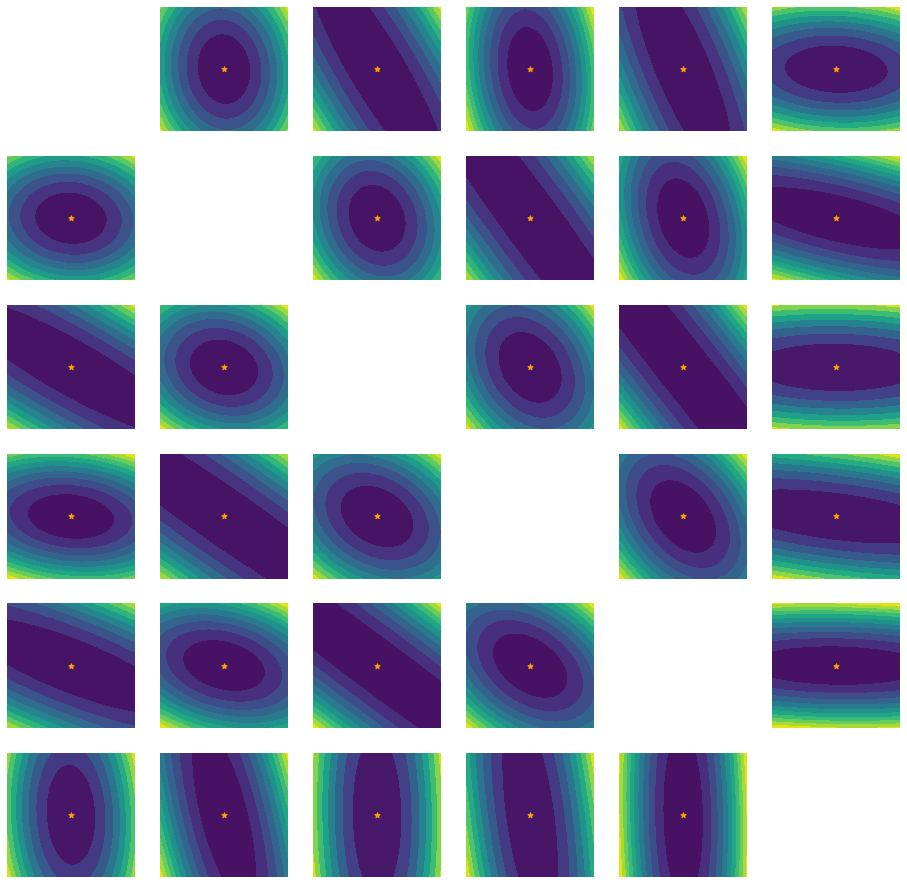

In [ ]:
# Combine the weights and the bias into a single parameter vector
solution = np.concatenate([linear_model.coef_, [linear_model.intercept_]])

# Calculate the power expansion of the features
X_expanded = np.concatenate([
    poly_expand.transform(X), np.ones(shape=(len(X), 1))
], axis=1)

# We'll plot a large matrix of plot, so let's create
# a 16 by 16 inch canvas
plt.figure(figsize=(16, 16))

# We'll loop over all pairs of weights
i_img = 0
for dim1 in trange(len(solution)):
  for dim2 in range(len(solution)):
    i_img += 1
    # Skip the diagonal
    if dim1 == dim2: continue

    # Create the grid of parameter values
    ww1, ww2 = np.meshgrid(
        np.linspace(solution[dim1] - 1000., solution[dim1] + 1000., 50),
        np.linspace(solution[dim2] - 1000., solution[dim2] + 1000., 50),
    )

    # Your turn! To calculate the map of MSE values, let's first
    # create `param_grid` - a 3D array of parameter values of the
    # following shape: (len(solution), ww1.shape[0], ww1.shape[1])
    #
    # I.e. `param_grid[i, :, :]` should equal to:
    #     `ww1` if `i` equals `dim1`;
    #     `ww2` if `i` equals `dim2`;
    #     `solution[i]` otherwise.
    
    param_grid = <YOUR CODE>

    # Automatic checks
    assert param_grid.shape == (len(solution),) + ww1.shape
    assert np.allclose(param_grid[dim1], ww1)
    assert np.allclose(param_grid[dim2], ww2)
    assert all(
        np.allclose(param_grid[i], solution[i])
        for i in range(len(solution)) if i not in (dim1, dim2)
    )

    # Your turn! Now it's time to calculate the MSE map, i.e. for each grid
    # element (i, j), you want `MSE_map[i, j]` to be equal to the MSE
    # for the model defined by parameters `param_grid[:, i, j]`.
    MSE_map = <YOUR CODE>

    # Automatic checks
    assert MSE_map.shape == ww1.shape
    for i in [0, -1]:
      for j in [0, -1]:
        assert np.isclose(
            ((X_expanded @ param_grid[:, i, j] - y)**2).mean(),
            MSE_map[i, j]
        ), f'Check failed for point {i, j}'

    plt.subplot(len(solution), len(solution), i_img)
    plt.axis('off')

    plt.contourf(ww1, ww2, MSE_map, levels=10);
    plt.scatter(solution[dim1], solution[dim2], marker='*', s=30, c='orange')

Note the relation between the amount of overfitting and correlation between parameters.

## Gradient descent

Let's look at MSE as a function of parameters:
$$\text{MSE}(w)=\frac{1}{N}\left\Vert X'\cdot w - y\right\Vert^2$$

Instead of minimizing it analytically, we can use numeric optimization with gradient descent. I.e. do the following procedure iteratively:
$$w\leftarrow w-\alpha\cdot\frac{\partial\text{MSE}(w)}{\partial w},$$
for some constant *learning rate* $\alpha$.

For the task below you'll need to derive the analytical formula for $\frac{\partial\text{MSE}(w)}{\partial w}$. **Note, that $w$ is a vector!** If not sure how to do it, check out the [matrix calculus cheat sheet](https://en.wikipedia.org/wiki/Matrix_calculus#Identities).

When done, play around with the power of the polynomial expansion, learning rate and the number of gradient descent steps.

100%|██████████| 1000/1000 [00:00<00:00, 18755.38it/s]


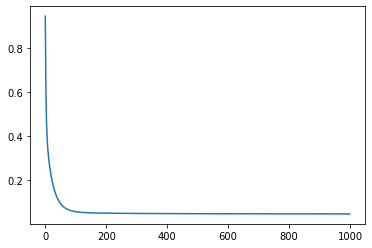

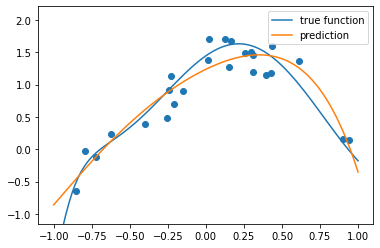

In [ ]:
# Initialize the model parameters with zeros
w = np.zeros(dtype=float, shape=X_expanded.shape[1])

loss_values = [] # a list to keep track of how the loss value changes
learning_rate = 0.1

# Training loop
for _ in trange(1000):
  # Your turn: calculate the gradient of MSE with respect to w:
  gradient = <YOUR CODE>

  # Automatic checks
  assert gradient.shape == w.shape
  assert (
      ((X_expanded @ w - y)**2).mean() > 
      ((X_expanded @ (w - 1.e-6 * gradient) - y)**2).mean()
  )

  # Gradient descent step
  w -= learning_rate * gradient

  # Calculate and record the new loss value
  loss_values.append(
      ((X_expanded @ w - y)**2).mean()
  )

# Plotting the evolution of loss values
plt.plot(loss_values);
plt.show()


# Plotting the solution
x = np.linspace(-1, 1, 101)
x_expanded = np.concatenate([
    poly_expand.transform(x[:,None]),
    np.ones(shape=(len(x), 1))
], axis=1)
plt.plot(x, true_function(x), label='true function')
plt.scatter(X, y);
plt.plot(x,
         x_expanded @ w, label='prediction')
plt.ylim(y.min() - 0.5, y.max() + 0.5)
plt.legend();

Did you notice that numeric solution is less prone to overfitting? Some intuition for that can be found in this post: https://distill.pub/2017/momentum/ (though not explicitly).